In [225]:
import numpy as np
import random
import pandas as pd
import math
from scipy.linalg import expm
seed = 42
random.seed(seed)
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [226]:
def cov_md(t1, t2, sigma2):
    dk = lambda r,p : (1+np.sqrt(3)*abs(r)/p[1])*np.exp(-np.sqrt(3)*abs(r)/p[1])
    K = np.zeros([len(t1), len(t2)])
    for i in range(len(t1)):
        for j in range(len(t2)):
            r = abs(t1[i] - t2[j])
            K[i,j] =  dk(r,sigma2) 
    return K

In [227]:
# matern 3/2 Covariance matrix
def cov_m(t1, t2, l):

    K = np.zeros([len(t1), len(t2)])
    for i in range(len(t1)):
        for j in range(len(t2)):
            r = abs(t1[i] - t2[j])
            K[i,j]=  (1 + np.sqrt(3)*r/l)* np.exp((-np.sqrt(3)) * r / l)
    return K

In [228]:
# Kalman filter and smoother for state space posterior calc
def kalmanSmoother(A,Q,H,P,vary,y):
    T = len(y)
    s_ = np.full([T,1], np.nan)
    v_ = np.full([T,1], np.nan)
    a = np.full([T,1], np.nan)
    Y = np.reshape(y,(1,1,T))
    lik=0
    if type(vary) == int:
        vary = vary * np.ones((T,1))
    #if vary == 1:
        #vary = vary * np.ones((T,1))
        
    m = np.zeros((A.shape[0],1))
    MS = np.zeros((m.shape[0],Y.shape[2]))
    PS = np.zeros((m.shape[0],m.shape[0],Y.shape[2]))
    Pfin = np.zeros((Y.shape[2],np.sum(H)))
    
    ### Forward filter
    for k in range(T):
        
        R = vary[k]
        # Prediction
        if k>0:

            m = A.dot(m)

            P = (A.dot(P)).dot(A.T) + Q
         
        #Kalman update
        if Y[:,:,k] is not np.nan:

            S = (H.dot(P)).dot(H.T) + R
            

            s_[k] = S
            
            K = P.dot(H.T)/S

            v = Y[:,:,k]-H.dot(m) 
            v_[k] = v
            a[k] = v/S

            m = m + K*v

            P = P - (K.dot(H)).dot(P)

         # Evaluate the energy (neg. log lik): Check this  ???
            lik = lik + 0.5*S.shape[0]*np.log(2*math.pi) + 0.5*np.log(S) + 0.5*(v.dot(v))/S
            
        
        
        PS[:,:,k] = P


        for i in range(len(MS[:,k])):
            MS[i,k]   = m[i]
            
        #print(MS)   
    
    
    MSF = MS.copy()
    PSF = PS[1,1,:]
    #print(MSF)
    # ### Backward smoother
    for k in range(MS.shape[1]-1,1,-1):
        
        # Smoothing step (using Cholesky for stability)
        PSk = PS[:,:,k]
        # Pseudo-prediction
        PSkp = (A.dot(PSk)).dot(A.T)+ Q

        L= np.linalg.cholesky(PSkp)# Solve the Cholesky factorization
        # Continue smoothing step
        G = (PSk.dot(A.T)).dot(np.linalg.inv(L.T)).dot(np.linalg.inv(L))
        # Do update

        m = MS[:,k].reshape(MS[:,k].shape[0],1) + G.dot((m-A.dot(MS[:,k].reshape(MS[:,k].shape[0],1))))

        P = PSk + (G.dot(P-PSkp)).dot(G.T)

        MS[:,k] = m.reshape(1, m.shape[0])

        PS[:,:,k] = P

        Pfin[k,:] = P[1,1]

    lik = -lik
    
    Xfin = MS.reshape(1,MS.shape[0],MS.shape[1])
    #print(Xfin.shape)
    Xfin = np.squeeze(Xfin).T

    return lik, Xfin, Pfin, MSF, PSF, s_, v_, a

In [229]:
# Need to add derivatives for both the Gram method and also the 
var_y = 1
x = np.linspace(1, 50, 50).astype(int)
test_loc  = range(25,30)
train_loc = range(50)
N = len(x[train_loc])
l = 1

In [230]:
K_s = cov_m(x[train_loc],x[train_loc],l)
#Q1 why eye
K = K_s + var_y*np.eye(N) 

In [231]:
mu = np.zeros(N)
y = np.random.multivariate_normal(mu, K).T

Ntest = len(test_loc)
K_K_star = cov_m(x[train_loc],x[test_loc],l)
K_star_star = cov_m(x[test_loc],x[test_loc],l)
L = scipy.linalg.cholesky(K)

alpha = np.linalg.inv(L.T).dot(np.linalg.inv(L).dot(y))

In [232]:
f_star = K_K_star.T.dot(alpha)
v = np.linalg.inv(L).dot(K_K_star)

v_star = K_star_star - v.T.dot(v)

log_p_y = - 0.5*y.T.dot(alpha) - np.sum(np.log(np.diag(L))) - (N/2)*np.log(2*math.pi)

f_inv = (K_K_star.T.dot(np.linalg.inv(K))).dot(y)

cov_inv = K_star_star - (K_K_star.T.dot(np.linalg.inv(K))).dot(K_K_star)

log_p_2 = (-0.5*y.T.dot(np.linalg.inv(K))).dot(y) - 0.5*np.log(np.linalg.det(K)) - N/2*np.log(2*math.pi)


In [233]:
A_ = np.array([[0,1],[-(np.sqrt(3)/l)**2,2*(-np.sqrt(3))/l]])
A = expm(A_)#???
H = np.array([[1,0]])
P = np.array([[1,0],[0,3/l**2]])
Q = P - A.dot(P).dot(A.T)

In [234]:
y_kf = np.NaN*x
y_kf[train_loc] = y

In [235]:
log_lik_ss,post_mean_ss_,post_cov_ss_,MFS, PSF, s,v,a = kalmanSmoother(A,Q,H,P,var_y,y_kf)

In [236]:
print('The log likelihood for state space is \n',log_lik_ss)
print('The log likelihood for chol is \n',log_p_y)
print('The log likelihood for inv is \n',log_p_2)

The log likelihood for state space is 
 [[-84.42590772]]
The log likelihood for chol is 
 -84.42997041666757
The log likelihood for inv is 
 -84.4259077153522


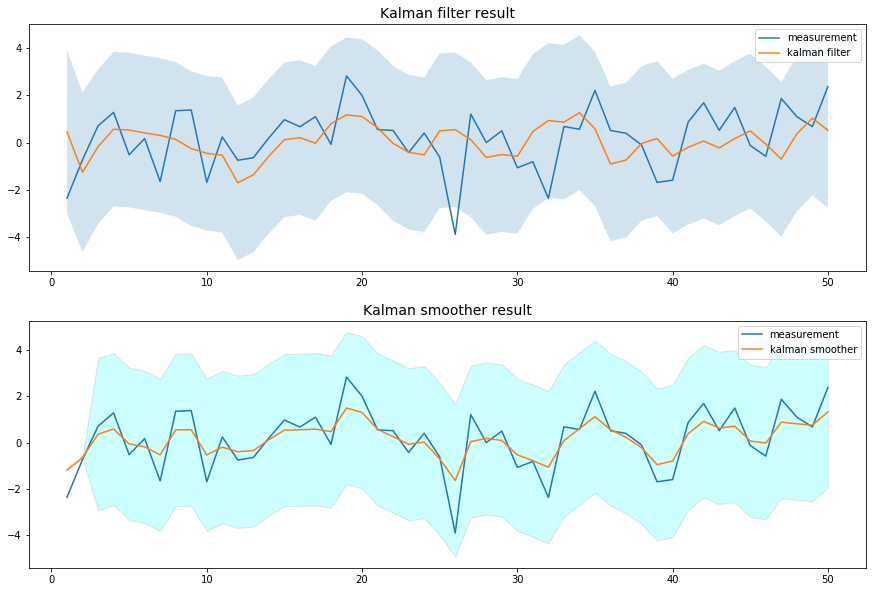

In [252]:
fig, ax = plt.subplots(2, 1, figsize=(15,10))


mu = MSF[0,:]
ax[0].plot(x,y,label="measurement")
ax[0].plot(x,mu,label="kalman filter")
vv = 2*np.sqrt(PSF).reshape(-1)
ax[0].fill_between(x, (mu-vv), (mu+vv), alpha=0.2)
ax[0].set_title('Kalman filter result', fontsize=14)
ax[0].legend()

mu = post_mean_ss_[:,0]
ax[1].plot(x,y,label="measurement")
ax[1].plot(x,mu,label="kalman smoother")
vv = 2*np.sqrt(post_cov_ss_).reshape(-1)
ax[1].fill_between(x, (mu-vv), (mu+vv), alpha=0.2, edgecolor='gray', facecolor='cyan')
ax[1].set_title('Kalman smoother result', fontsize=14)
ax[1].legend()


plt.show()

In [238]:
param = np.array([0.6,1])
K_u= cov_md(x[train_loc],x[train_loc],param)
alpha = np.linalg.inv(K).dot(y).reshape(alpha.shape[0],1)
alpha_= alpha.dot(alpha.T) - np.linalg.inv(K)
score = 0.5*np.trace(alpha_.dot(K_u))


In [239]:
invK = np.linalg.inv(L.T).dot(np.linalg.inv(L).dot(np.eye(N)))
eg = 0.5*np.trace(invK) - 0.5*(alpha.T.dot(alpha))